In [28]:
# *************************
#  SETUP
# *************************

!pip install -q transformers torch scikit-learn pandas numpy matplotlib tqdm seaborn

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("Setup complete. PyTorch:", torch.__version__)


Setup complete. PyTorch: 2.8.0+cu126


In [29]:
# *****************************
#  LOAD & CLEAN DATA
# *****************************

import re # Import the regular expression module

file_path = "/content/sentiment-analysis.csv"  # Update path if different

def parse_line_extract_text_and_sentiment(line):
    """Extract first quoted text and next token as sentiment."""
    line = line.strip()
    if not line:
        return None, None
    m = re.search(r'"{1,}(.+?)"{1,}', line)
    if not m:
        parts = [p.strip().strip('"') for p in line.split(",")]
        if len(parts) >= 2:
            return parts[0], parts[1]
        return None, None
    text = m.group(1).strip()
    remaining = line[m.end():].lstrip(', ').strip()
    sentiment = None
    if remaining:
        sentiment = remaining.split(",", 1)[0].strip().strip('"').strip()
    return text, sentiment

rows = []
with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

start_idx = 0
if lines and "Text" in lines[0] and "Sentiment" in lines[0]:
    start_idx = 1

for i, line in enumerate(lines[start_idx:], start=start_idx+1):
    text, sentiment = parse_line_extract_text_and_sentiment(line)
    if text and sentiment:
        rows.append((text, sentiment))

df = pd.DataFrame(rows, columns=["Text", "Sentiment"])
print("Loaded rows:", len(df))
print(df.head())
print("\nLabel distribution:\n", df["Sentiment"].value_counts())

Loaded rows: 96
                                               Text Sentiment
0                              I love this product!  Positive
1                         The service was terrible.  Negative
2                            This movie is amazing!  Positive
3  I'm so disappointed with their customer support.  Negative
4                Just had the best meal of my life!  Positive

Label distribution:
 Sentiment
Positive    53
Negative    43
Name: count, dtype: int64


In [30]:
# ********************************************************
# PREPROCESS & LABEL ENCODE (BINARY SENTIMENT)
# ********************************************************
def clean_text(s):
    s = re.sub(r'\s+', ' ', s.strip())
    return s

df["Text"] = df["Text"].astype(str).apply(clean_text)
df["Sentiment"] = df["Sentiment"].astype(str).str.strip().str.title()

# Keep only Positive/Negative
df = df[df["Sentiment"].isin(["Positive", "Negative"])].reset_index(drop=True)

le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["Sentiment"])

print("Classes:", list(le.classes_))
print(df.groupby("Sentiment").size())


Classes: ['Negative', 'Positive']
Sentiment
Negative    43
Positive    53
dtype: int64


In [31]:
# *******************************
# LABEL ENCODING
# *******************************

# Encode sentiment labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["Sentiment"])

print("Encoded label mapping:")
for i, label in enumerate(le.classes_):
    print(f"{i} → {label}")

df.head()


Encoded label mapping:
0 → Negative
1 → Positive


,Text,Sentiment,label_encoded
0,I love this product!,Positive,1
1,The service was terrible.,Negative,0
2,This movie is amazing!,Positive,1
3,I'm so disappointed with their customer support.,Negative,0
4,Just had the best meal of my life!,Positive,1


In [32]:
# **********************************
#   DATA SPLIT (FINAL FIX)
# **********************************

from sklearn.model_selection import train_test_split

# Clean dataframe: ensure no missing values
df = df.dropna(subset=['Text', 'label_encoded']).reset_index(drop=True)

# Split into train, validation, and test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_encoded'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label_encoded'])

# Reset indices to avoid key errors
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f" Split complete: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
print(" Classes in train:", train_df['label_encoded'].unique())
print(train_df.head())


 Split complete: Train=76, Val=10, Test=10
 Classes in train: [1 0]
                                                Text Sentiment  label_encoded
0               I loved the movie! It was fantastic!  Positive              1
1  This song always puts me in a nostalgic mood. ...  Positive              1
2  The food at this restaurant was disappointing....  Negative              0
3     This movie is a masterpiece! I was blown away.  Positive              1
4  This album is a masterpiece. Every song is a w...  Positive              1


In [33]:
# =======================
# Dataset CLASS (FINAL FIX)
# =======================
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        # Ensure clean continuous index to prevent KeyError
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Ensure idx is always valid integer
        if idx >= len(self.df):
            raise IndexError(f"Index {idx} out of range for dataset length {len(self.df)}")

        text = str(self.df.loc[idx, "Text"])
        label = int(self.df.loc[idx, "label_encoded"])

        encoded = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [34]:
# =======================
#  FIXED VERSION (Tokenizer + Split + Dataloaders)
# =======================
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import DataLoader

# Define the tokenizer before dataset usage
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Split the dataset (using stratified split)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["label_encoded"],
    random_state=RANDOM_SEED
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label_encoded"],
    random_state=RANDOM_SEED
)

print(f"Train / Val / Test: {len(train_df)} / {len(val_df)} / {len(test_df)}")

# DataLoader setup
MAX_LEN = 128
BATCH_SIZE = 16

# Ensure SentimentDataset class is already defined before this cell
train_dataset = SentimentDataset(train_df, tokenizer, MAX_LEN)
val_dataset   = SentimentDataset(val_df, tokenizer, MAX_LEN)
test_dataset  = SentimentDataset(test_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("DataLoaders created successfully!")


Train / Val / Test: 67 / 14 / 15
DataLoaders created successfully!


In [35]:
# ********************************
#  MODEL SETUP (BINARY SENTIMENT)
# ********************************
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_labels = 2  # Only positive/negative
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)

EPOCHS = 10
LR = 2e-5

optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()
print(" Model, optimizer, and loss function ready.")


Device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model, optimizer, and loss function ready.


In [36]:
# ***************************
# TRAINING (CLEAN)
# ***************************

best_f1 = 0.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attn, labels=labels)
        loss = outputs.loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            )
            pred = torch.argmax(outputs.logits, dim=1)
            preds += pred.cpu().tolist()
            gold += batch["labels"].tolist()

    acc = accuracy_score(gold, preds)
    f1 = f1_score(gold, preds, average="macro")
    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Acc={acc:.4f}, Val F1={f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model.pt")
        print(" Best model saved.")


Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Epoch 1: Train Loss=0.6405, Val Acc=0.6429, Val F1=0.5238
 Best model saved.


Epoch 2: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Epoch 2: Train Loss=0.5337, Val Acc=1.0000, Val F1=1.0000
 Best model saved.


Epoch 3: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Epoch 3: Train Loss=0.4055, Val Acc=0.9286, Val F1=0.9251


Epoch 4: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 4: Train Loss=0.2605, Val Acc=0.9286, Val F1=0.9251


Epoch 5: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 5: Train Loss=0.2012, Val Acc=0.9286, Val F1=0.9251


Epoch 6: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Epoch 6: Train Loss=0.1348, Val Acc=1.0000, Val F1=1.0000


Epoch 7: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Epoch 7: Train Loss=0.0938, Val Acc=1.0000, Val F1=1.0000


Epoch 8: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


Epoch 8: Train Loss=0.0796, Val Acc=1.0000, Val F1=1.0000


Epoch 9: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Epoch 9: Train Loss=0.0628, Val Acc=1.0000, Val F1=1.0000


Epoch 10: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 10: Train Loss=0.0578, Val Acc=1.0000, Val F1=1.0000


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]



Test Accuracy: 1.0000
Test F1-score: 1.0000

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         7
    Positive       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



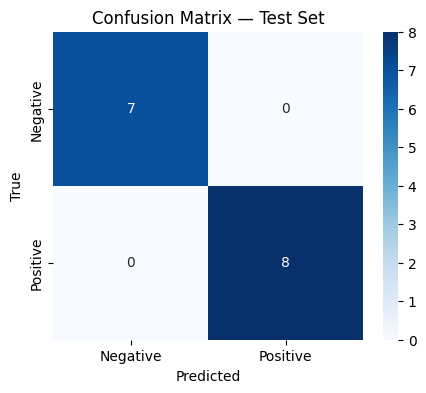

In [37]:
# =======================
# FIXED EVALUATION (NO FLIP)
# =======================
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attn)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds += preds.cpu().tolist()
        all_labels += labels.cpu().tolist()

acc = accuracy_score(all_labels, all_preds)
f1  = f1_score(all_labels, all_preds, average="macro")

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=le.classes_))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix — Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [38]:
test_sentences = [
    "The movie was absolutely breathtaking!",  # Positive
    "The food was cold and tasteless.",         # Negative
    "Worst experience ever, never again.",      # Negative
    "Everything worked perfectly, highly recommended!",  # Positive
    "The app crashes every time I open it.",    # Negative
    "Battery lasts all day, super satisfied!"   # Positive
]

model.eval()
for text in test_sentences:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    label = le.inverse_transform([pred])[0]
    print(f" {text}\n→ Predicted Sentiment: {label}\n")


 The movie was absolutely breathtaking!
→ Predicted Sentiment: Positive

 The food was cold and tasteless.
→ Predicted Sentiment: Negative

 Worst experience ever, never again.
→ Predicted Sentiment: Negative

 Everything worked perfectly, highly recommended!
→ Predicted Sentiment: Positive

 The app crashes every time I open it.
→ Predicted Sentiment: Negative

 Battery lasts all day, super satisfied!
→ Predicted Sentiment: Positive



In [39]:
# =======================
#  EXAMPLE PREDICTIONS
# =======================
def predict_sentiment(text):
    model.eval()
    enc = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    with torch.no_grad():
        outputs = model(
            input_ids=enc["input_ids"].to(device),
            attention_mask=enc["attention_mask"].to(device)
        )
        pred = torch.argmax(outputs.logits, dim=1).cpu().item()
    label = le.inverse_transform([pred])[0]
    return label

# 🔍 Test with sample sentences
examples = [
    "I absolutely loved this product!",
    "It was okay, nothing special.",
    "Terrible service, very disappointed."
]

for text in examples:
    print(f" {text}\n→ Predicted Sentiment: {predict_sentiment(text)}\n")


 I absolutely loved this product!
→ Predicted Sentiment: Positive

 It was okay, nothing special.
→ Predicted Sentiment: Negative

 Terrible service, very disappointed.
→ Predicted Sentiment: Negative



In [40]:
# **********************************
# SAVE TOKENIZER & ENCODER
# **********************************
tokenizer.save_pretrained("./bert_tokenizer/")
torch.save(le, "label_encoder.pkl")
print("✅ Tokenizer and label encoder saved.")


✅ Tokenizer and label encoder saved.


In [41]:
# *************************************
#  REFINED DARK SENTIMENT ANALYZER
# *************************************
!pip install -q gradio

import gradio as gr
import torch
import torch.nn.functional as F

model.eval()

# --- Auto-detect label flip ---
def detect_flip():
    love = "I love this product! It's amazing."
    hate = "I hate this product. It's terrible."

    enc_l = tokenizer(love, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    enc_h = tokenizer(hate, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

    with torch.no_grad():
        out_l = model(**enc_l)
        out_h = model(**enc_h)
        p_l = int(torch.argmax(out_l.logits, dim=1).cpu().item())
        p_h = int(torch.argmax(out_h.logits, dim=1).cpu().item())

    try:
        label_l = le.inverse_transform([p_l])[0]
        label_h = le.inverse_transform([p_h])[0]
    except Exception:
        label_map = {0: "Negative", 1: "Positive"}
        label_l = label_map.get(p_l, "Unknown")
        label_h = label_map.get(p_h, "Unknown")

    if label_l.lower().startswith("pos") and label_h.lower().startswith("neg"):
        return False
    if label_l.lower().startswith("neg") and label_h.lower().startswith("pos"):
        return True
    return False

FLIP_PRED = detect_flip()

# --- Prediction Function ---
def predict_gradio(text):
    if not text or not text.strip():
        return "<div style='padding:12px;color:#fca5a5'> Please enter some text.</div>"

    enc = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        out = model(**enc)
        pred = int(torch.argmax(out.logits, dim=1).cpu().item())

    if FLIP_PRED:
        pred = 1 - pred

    try:
        label = le.inverse_transform([pred])[0]
    except Exception:
        label = "Positive" if pred == 1 else "Negative"

    # Stylish Sentiment Card
    if label.lower().startswith("pos"):
        bg = "#062C1E"
        border = "#10B981"
        emoji = "😊"
        text_color = "#A7F3D0"
        title = "POSITIVE"
    elif label.lower().startswith("neg"):
        bg = "#2C0606"
        border = "#F87171"
        emoji = "😠"
        text_color = "#FCA5A5"
        title = "NEGATIVE"
    else:
        bg = "#1E1B4B"
        border = "#818CF8"
        emoji = "😐"
        text_color = "#C7D2FE"
        title = "NEUTRAL"

    html = f"""
    <div style='
        background: linear-gradient(135deg, {bg}, #0F172A);
        border: 2px solid {border};
        border-radius: 16px;
        padding: 24px;
        color: {text_color};
        text-align: center;
        font-family: Segoe UI, sans-serif;
        font-size: 20px;
        font-weight: 600;
        margin-top: 20px;
        box-shadow: 0 0 25px rgba(0,0,0,0.4);
        transition: all 0.3s ease;
    '>
        <div style='font-size:26px'>{emoji} Sentiment: {title}</div>
        <div style='margin-top:10px; font-size:15px; color:#cbd5e1'>{text}</div>
    </div>
    """
    return html

# --- Debug Function ---
def debug_logits(text):
    if not text or not text.strip():
        return " Please enter text first."
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    with torch.no_grad():
        out = model(**enc)
        logits = out.logits.cpu().numpy().flatten()
        probs = F.softmax(out.logits, dim=1).cpu().numpy().flatten()
    return f"**Raw logits:** {logits}\n**Probabilities:** {probs}"

# --- Header HTML ---
header_html = """
<div style="text-align:center;font-family:Segoe UI, Roboto, Arial;margin-bottom:10px;">
  <h1 style="color:#10B981;margin-bottom:5px;">💬 Sentiment Analyzer</h1>
  <p style="color:#9CA3AF;font-size:15px;">Type something and analyze its emotional tone instantly!</p>
</div>
"""

# --- Dark Theme CSS ---
dark_css = """
body, .gradio-container {
    background: radial-gradient(circle at top left, #0f172a, #020617);
    color: #e2e8f0;
}
textarea, input, .gr-input, .gr-box {
    background-color: #1e293b !important;
    color: #e2e8f0 !important;
}
button {
    background: linear-gradient(90deg, #10B981, #14B8A6) !important;
    color: white !important;
    font-weight: bold !important;
    border: none !important;
    border-radius: 8px !important;
    transition: 0.3s;
}
button:hover {
    background: linear-gradient(90deg, #14B8A6, #10B981) !important;
    transform: scale(1.03);
}
"""

# --- Build Gradio UI ---
with gr.Blocks(css=dark_css) as demo:
    gr.HTML(header_html)

    text_input = gr.Textbox(label="📝 Enter Text", placeholder="Type your feedback...", lines=3)
    with gr.Row():
        analyze = gr.Button("🔍 Analyze Sentiment", variant="primary")
        debug_btn = gr.Button(" Debug Logits", variant="secondary")

    # Output placed BELOW for cleaner UI
    output_html = gr.HTML("<div style='padding:20px;color:#9CA3AF;text-align:center;'>Your sentiment will appear here.</div>")
    debug_output = gr.Markdown("")

    analyze.click(fn=predict_gradio, inputs=[text_input], outputs=[output_html])
    debug_btn.click(fn=debug_logits, inputs=[text_input], outputs=[debug_output])

    note = " Auto label correction is ON." if FLIP_PRED else " Label mapping appears normal."
    gr.HTML(f"<div style='font-size:13px;color:#94A3B8;margin-top:10px;text-align:center'>{note}</div>")

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4784a707db03f453cf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
